In [1]:
import shutup
shutup.please()

import gym
import src.environments.continuous.stock_trading  

import numpy as np
import pandas as pd 

from tqdm.notebook import trange, tqdm

### Train the agent
* Run it until he has a running average above the success_threshold
* Use a large number of episodes for the running average ( 1000+ ) so if even it falls into a privileged sample, it wont be prone to error

In [2]:
def environment():
    env = gym.make('StockTradingEnvironment-v0',
        use_technical_indicators= [
        "macd",
        "boll_ub",
        "boll_lb",
        "rsi_30",
        "cci_30",
        "dx_30",
        "close_30_sma",
        "close_60_sma",
    ])
    
    poc_threshold = 0.3 # 10% 
    print('* Original success threshold', env.success_threshold)
    
    print('* POC success threshold', poc_threshold)
    print()
    
    env.success_threshold = poc_threshold
    return env

# from src.environments.continuous.trading import environment

In [3]:
from src.agents.actor_critic.a2c import A2CAgent

In [4]:
agent=A2CAgent(environment, epochs=1, actor_learning_rate=0.000025,critic_learning_rate=0.000025,policy="CNN")
agent.load()


* Original success threshold 0.0855973435323849
* POC success threshold 0.1

@TODO Agent._load_agent_configuration()


Episode * 100 * Moving Avg Reward is ==> 0.04352 * Last Reward was ==> -0.12891 
Episode * 200 * Moving Avg Reward is ==> 0.05082 * Last Reward was ==> 0.07479 
Episode * 300 * Moving Avg Reward is ==> 0.05965 * Last Reward was ==> 0.29955 
Episode * 400 * Moving Avg Reward is ==> 0.06660 * Last Reward was ==> 0.15068 
Episode * 500 * Moving Avg Reward is ==> 0.06391 * Last Reward was ==> 0.28067 
Episode * 600 * Moving Avg Reward is ==> 0.05900 * Last Reward was ==> 0.22462 
Episode * 700 * Moving Avg Reward is ==> 0.05861 * Last Reward was ==> 0.25963 
Episode * 800 * Moving Avg Reward is ==> 0.05862 * Last Reward was ==> 0.01233 
Episode * 900 * Moving Avg Reward is ==> 0.05671 * Last Reward was ==> -0.22894 
Episode * 1000 * Moving Avg Reward is ==> 0.05806 * Last Reward was ==> -0.04058 
Episode * 1100 * Moving Avg Reward is ==> 0.05752 * Last Reward was ==> -0.12966 * Total episodes ending on loss: 398/1000 
Episode * 1200 * Moving Avg Reward is ==> 0.05718 * Last Reward was ==> 

Episode * 6600 * Moving Avg Reward is ==> 0.04639 * Last Reward was ==> 0.18563 * Total episodes ending on loss: 432/1000 
Episode * 6700 * Moving Avg Reward is ==> 0.05010 * Last Reward was ==> 0.32117 * Total episodes ending on loss: 422/1000 
Episode * 6800 * Moving Avg Reward is ==> 0.04722 * Last Reward was ==> -0.18897 * Total episodes ending on loss: 431/1000 
Episode * 6900 * Moving Avg Reward is ==> 0.04635 * Last Reward was ==> 0.27015 * Total episodes ending on loss: 430/1000 
Episode * 7000 * Moving Avg Reward is ==> 0.05132 * Last Reward was ==> 0.11440 * Total episodes ending on loss: 415/1000 
Episode * 7100 * Moving Avg Reward is ==> 0.05252 * Last Reward was ==> -0.10265 * Total episodes ending on loss: 419/1000 
Episode * 7200 * Moving Avg Reward is ==> 0.05456 * Last Reward was ==> 0.26785 * Total episodes ending on loss: 413/1000 
Episode * 7300 * Moving Avg Reward is ==> 0.05851 * Last Reward was ==> -0.16198 * Total episodes ending on loss: 406/1000 
Episode * 740

Episode * 12700 * Moving Avg Reward is ==> 0.04557 * Last Reward was ==> -0.16009 * Total episodes ending on loss: 419/1000 
Episode * 12800 * Moving Avg Reward is ==> 0.04633 * Last Reward was ==> 0.18823 * Total episodes ending on loss: 420/1000 
Episode * 12900 * Moving Avg Reward is ==> 0.04878 * Last Reward was ==> -0.19008 * Total episodes ending on loss: 415/1000 
Episode * 13000 * Moving Avg Reward is ==> 0.05068 * Last Reward was ==> 0.27513 * Total episodes ending on loss: 415/1000 
Episode * 13100 * Moving Avg Reward is ==> 0.05038 * Last Reward was ==> 0.01378 * Total episodes ending on loss: 417/1000 
Episode * 13200 * Moving Avg Reward is ==> 0.04767 * Last Reward was ==> 0.13724 * Total episodes ending on loss: 431/1000 
Episode * 13300 * Moving Avg Reward is ==> 0.05386 * Last Reward was ==> 0.18823 * Total episodes ending on loss: 424/1000 
Episode * 13400 * Moving Avg Reward is ==> 0.05845 * Last Reward was ==> 0.24752 * Total episodes ending on loss: 414/1000 
Episod

Episode * 18800 * Moving Avg Reward is ==> 0.06865 * Last Reward was ==> 0.18898 * Total episodes ending on loss: 334/1000 
* Models saved *

New historical moving average record: 0.06865

* Models saved *

New historical moving average record: 0.06882

* Models saved *

New historical moving average record: 0.06919

* Models saved *

New historical moving average record: 0.06939

* Models saved *

New historical moving average record: 0.06958

* Models saved *

New historical moving average record: 0.06978

Episode * 18900 * Moving Avg Reward is ==> 0.06783 * Last Reward was ==> 0.20751 * Total episodes ending on loss: 328/1000 
Episode * 19000 * Moving Avg Reward is ==> 0.06156 * Last Reward was ==> 0.08095 * Total episodes ending on loss: 333/1000 
Episode * 19100 * Moving Avg Reward is ==> 0.06047 * Last Reward was ==> 0.15272 * Total episodes ending on loss: 334/1000 
Episode * 19200 * Moving Avg Reward is ==> 0.05892 * Last Reward was ==> 0.10205 * Total episodes ending on loss: 

Episode * 23500 * Moving Avg Reward is ==> 0.04929 * Last Reward was ==> -0.21431 * Total episodes ending on loss: 393/1000 
Episode * 23600 * Moving Avg Reward is ==> 0.04932 * Last Reward was ==> -0.03709 * Total episodes ending on loss: 397/1000 
Episode * 23700 * Moving Avg Reward is ==> 0.04802 * Last Reward was ==> -0.19891 * Total episodes ending on loss: 408/1000 
Episode * 23800 * Moving Avg Reward is ==> 0.05246 * Last Reward was ==> 0.20910 * Total episodes ending on loss: 404/1000 
Episode * 23900 * Moving Avg Reward is ==> 0.05052 * Last Reward was ==> -0.19929 * Total episodes ending on loss: 413/1000 
Episode * 24000 * Moving Avg Reward is ==> 0.05358 * Last Reward was ==> -0.00318 * Total episodes ending on loss: 410/1000 
Episode * 24100 * Moving Avg Reward is ==> 0.05230 * Last Reward was ==> 0.21978 * Total episodes ending on loss: 421/1000 
Episode * 24200 * Moving Avg Reward is ==> 0.05624 * Last Reward was ==> 0.25519 * Total episodes ending on loss: 407/1000 
Epi

Episode * 30100 * Moving Avg Reward is ==> 0.05222 * Last Reward was ==> 0.18374 * Total episodes ending on loss: 378/1000 
Episode * 30200 * Moving Avg Reward is ==> 0.05156 * Last Reward was ==> 0.23201 * Total episodes ending on loss: 387/1000 
Episode * 30300 * Moving Avg Reward is ==> 0.05024 * Last Reward was ==> 0.01895 * Total episodes ending on loss: 387/1000 
Episode * 30400 * Moving Avg Reward is ==> 0.04849 * Last Reward was ==> 0.15037 * Total episodes ending on loss: 388/1000 
Episode * 30500 * Moving Avg Reward is ==> 0.04644 * Last Reward was ==> -0.01518 * Total episodes ending on loss: 385/1000 
Episode * 30600 * Moving Avg Reward is ==> 0.04689 * Last Reward was ==> -0.28879 * Total episodes ending on loss: 378/1000 
Episode * 30700 * Moving Avg Reward is ==> 0.04664 * Last Reward was ==> -0.22603 * Total episodes ending on loss: 368/1000 
Episode * 30800 * Moving Avg Reward is ==> 0.04695 * Last Reward was ==> -0.13947 * Total episodes ending on loss: 365/1000 
Epis

Episode * 33100 * Moving Avg Reward is ==> 0.08293 * Last Reward was ==> 0.15832 * Total episodes ending on loss: 79/1000 
* Models saved *

New historical moving average record: 0.08433

Episode * 33200 * Moving Avg Reward is ==> 0.08341 * Last Reward was ==> 0.06870 * Total episodes ending on loss: 76/1000 
Episode * 33300 * Moving Avg Reward is ==> 0.08382 * Last Reward was ==> 0.05351 * Total episodes ending on loss: 67/1000 
Episode * 33400 * Moving Avg Reward is ==> 0.08121 * Last Reward was ==> 0.08967 * Total episodes ending on loss: 67/1000 
Episode * 33500 * Moving Avg Reward is ==> 0.08404 * Last Reward was ==> 0.13401 * Total episodes ending on loss: 54/1000 
* Models saved *

New historical moving average record: 0.08435

* Models saved *

New historical moving average record: 0.08437

* Models saved *

New historical moving average record: 0.08438

* Models saved *

New historical moving average record: 0.08442

* Models saved *

New historical moving average record: 0.08

* Models saved *

New historical moving average record: 0.09092

* Models saved *

New historical moving average record: 0.09094

* Models saved *

New historical moving average record: 0.09104

* Models saved *

New historical moving average record: 0.09110

* Models saved *

New historical moving average record: 0.09112

* Models saved *

New historical moving average record: 0.09113

* Models saved *

New historical moving average record: 0.09115

* Models saved *

New historical moving average record: 0.09127

* Models saved *

New historical moving average record: 0.09133

* Models saved *

New historical moving average record: 0.09138

* Models saved *

New historical moving average record: 0.09155

* Models saved *

New historical moving average record: 0.09156

* Models saved *

New historical moving average record: 0.09159

* Models saved *

New historical moving average record: 0.09168

* Models saved *

New historical moving average record: 0.09180

* Models saved *

New his

* Models saved *

New historical moving average record: 0.09761

* Models saved *

New historical moving average record: 0.09769

* Models saved *

New historical moving average record: 0.09769

* Models saved *

New historical moving average record: 0.09777

* Models saved *

New historical moving average record: 0.09783

* Models saved *

New historical moving average record: 0.09783

* Models saved *

New historical moving average record: 0.09785

* Models saved *

New historical moving average record: 0.09788

Episode * 34700 * Moving Avg Reward is ==> 0.09802 * Last Reward was ==> 0.20955 * Total episodes ending on loss: 29/1000 
* Models saved *

New historical moving average record: 0.09802

* Models saved *

New historical moving average record: 0.09803

* Models saved *

New historical moving average record: 0.09809

* Models saved *

New historical moving average record: 0.09815

* Models saved *

New historical moving average record: 0.09831

* Models saved *

New historical

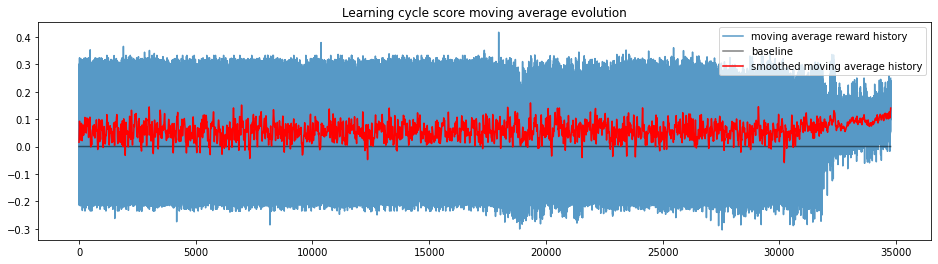

A2C + CNN + 0.25 threshold -> Executed in 1h 1m 4s, finished 18:43:51 2022-08-08


<Figure size 432x288 with 0 Axes>

In [5]:
agent.env.mode = "train"
agent.learning_log.episodes = 0
agent.learn(
    timesteps=-1, 
    log_every=100,
    success_threshold_lookback=1000,
    success_strict=False,
)

print('A2C + CNN + 0.19 threshold -> Executed in 1h 1m 4s, finished 18:43:51 2022-08-08')

In [7]:
agent.training_duration

'02:46:34'

### Test the results
* Runs a set of episodes with **unseen data**
* Stores the results in a csv file for later consulting

In [ ]:
success = 0
n_tests = 10000

scores = []
targets = []
portfolio_target_ratios = []
initial_investments = []

for i in trange(n_tests):
    state = agent.env.reset(visualize=False,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    
    targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    initial_investments.append(agent.env.initial_investment)

    while not done:
        agent.env.render()
        
        # Select action
        action, action_onehot, prediction = agent.choose_action(state)
        
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, info = agent.env.step(action)
        
        # End of episode, track scores here
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1

        step+=1
        state = next_state
        score += reward
    
    # Track scores and ratios
    scores.append(score)
    portfolio_target_ratios.append(info["portfolio_value"]/info["episode_target"] -1)
    
    
test_results_dataframe = pd.DataFrame([[
    n_tests,
    str(round(np.mean(scores)*100,3))+'%',
    str(round(np.mean(targets)*100,3))+'%',
    str(round(np.mean(portfolio_target_ratios)*100,3))+'%',
    str(round(min(scores)*100,3))+'%',
    str(round(max(scores)*100,3))+'%',
    str(round((success/n_tests)*100,3)) +'%'
]],
    columns=[
        '# Blind tests',
        '% Average portfolio return', 
        '% Desired portfolio return', 
        'Portfolio/Target rate',
        '% Historical minimum return',
        '% Historical maximum return', 
        '% Episodes concluded with positive outcome'
    ]
)


agent.results_writer.store_test_results(agent,test_results_dataframe)

test_results_dataframe.T

### Visual test
* Runs a set of episodes with **unseen data**
* See the evolution in real time


In [ ]:
success = 0
n_tests = 10

scores = []
targets = []


for i in trange(n_tests):
    state = agent.env.reset(visualize=True,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    initial_portfolio = agent.env.portfolio_value

    while not done:
        agent.env.render()
        
        # Select desired action
        action, action_onehot, prediction = agent.choose_action(state)

        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, _ = agent.env.step(action)

        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1

        step+=1
        state = next_state
        score += reward
    
    scores.append(score)

agent.env.close()

### Transactions profit
* Track how much the agent gained by doing purchases and sales
* Doesn't track the portfolio value 
* Already has the fees discounted

In [ ]:
success = 0
n_tests = 10000

test_results_data = []
test_results_columns = [
    'dataset id',
    'episode start date', 
    'episode end date',
    'episode working days',
    'total transactions',
    'total transaction profit',
    "dataframe hash",
    "agent hash"
]

print('NOTE: This test only tracks the transactions profit. ')

for i in trange(n_tests):
    trading_history = []
    state = agent.env.reset(visualize=False,mode="test")
    step = 0
    score = 0
    reward = 0
    done = False
    #targets.append((agent.env.episode_target-agent.env.initial_investment)/agent.env.initial_investment)
    #initial_portfolio = agent.env.portfolio_value
    
    j = 0
    num_stocks = 0
    while not done:
        agent.env.render()
        
        # Select desired action
        action, action_onehot, prediction = agent.choose_action(state)
        current_price = agent.env.df.iloc[agent.env.current_step -1]['close']
        
        if action == agent.env.ACTIONS.BUY:
            discounted_price = current_price * (1+agent.env.fees.BUY) 
            if agent.env.stock_held < agent.env.maximum_stocks_held and agent.env.cash_in_hand >= discounted_price:
                num_stocks +=1
                trading_history.append(['buy', discounted_price])
        elif action == agent.env.ACTIONS.SELL:
            if agent.env.stock_held > 0:
                discounted_price = current_price * (1-agent.env.fees.SELL) 
                trading_history.append(['sell', discounted_price])
                num_stocks =0
                
        # Retrieve new state, reward, and whether the state is terminal
        next_state, reward, done, _ = agent.env.step(action)

        # Update current state
        if done :
            if agent.env.portfolio_value > agent.env.initial_investment:
                success +=1
                
            profits = []
            purchases = []
            for e in trading_history:
                if e[0] == 'buy':
                    purchases.append(e[1])
                else:
                    profits.append((e[1]* len(purchases) - sum(purchases)) / sum(purchases))
                    purchases.clear() 
                    
            test_results_data.append([
                agent.env.dataset_idx,
                agent.env.df.iloc[agent.env.lookback].name,
                agent.env.df.iloc[-1].name,
                agent.env.window_size,
                len(profits),
                sum(profits)*100,
                agent.env.df_name,
                agent.hash
            ])


        step+=1
        state = next_state
        score += reward
    

agent.env.close()


pd.DataFrame(test_results_data,columns=test_results_columns)

In [ ]:
transaction_results_df = pd.DataFrame(test_results_data,columns=test_results_columns)

In [ ]:
transaction_results_df.sort_values(by="dataset id")

In [ ]:
transaction_results_df[transaction_results_df['total transaction profit'] <= 0]

In [ ]:
failed_episodes_df = transaction_results_df[transaction_results_df['total transaction profit'] <= 0]
failed_episodes_idx = failed_episodes_df['dataset id'].unique()
failed_episodes_idx.sort()

In [ ]:
len(transaction_results_df[transaction_results_df['total transaction profit'] <= 0]['dataset id'].unique()),len(transaction_results_df[transaction_results_df['total transaction profit'] > 0]['dataset id'].unique())

In [ ]:
import matplotlib.pyplot as plt 

for idx in failed_episodes_idx:
    plt.figure(figsize=(16,4))
    plt.plot(agent.env.df['close'])
    plt.title('#'+str(idx)+' - ' + str(len(failed_episodes_df[failed_episodes_df['dataset id'] == idx])) +'/' + str(len(transaction_results_df[transaction_results_df['dataset id'] == idx])))

In [ ]:
idx

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(agent.env.df['close'])
plt.title('#'+str(idx)+' - ' + str(len(failed_episodes_df[failed_episodes_df['dataset id'] == idx])) +'/' + str(len(transaction_results_df[transaction_results_df['dataset id'] == idx])))